# RCS analysis and paper plots

In [1]:
from analysis_functions import *
from plotting_functions import *
import ast
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
mpl.rcParams.update({'errorbar.capsize' : 3})
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 
mpl.rcParams.update({'font.size': 14})

Define all the pairs of qubit number N and depth d that are explored in the data:

In [2]:
Nd_pairs_xeb = [(16,12),(24,12),(32,12),(40,12),(48,12),(56,8),(56,10),(56,12),(56,14),(56,16),(56,18),(56,20)]
Nd_pairs_t1qrb = [(N,d) for N in [16,24,32,40,48,56] for d in [4,16,32,48,64,96]]
Nd_pairs_mb = [(16,12),(24,12),(32,12),(40,12),(48,12),(56,8),(56,10),(56,12),(56,14),(56,16),(56,18),(56,20),(56,24)]
Nd_pairs_xeb_N40_verification = [(40,8),(40,10),(40,12),(40,14),(40,16),(40,18),(40,20)]
Nd_pairs_t1qrb_N40_verification = [(40,d) for d in [4,16,32,48,64,96]]
Nd_pairs_mb_N40_verification = [(40,8),(40,10),(40,12),(40,14),(40,16),(40,18),(40,20)]

Define parameters of H2 (see system_benchmarking, and Table I in arXiv:2406.XXXXX) and other parameters for analysis and plotting.

In [3]:
spam_uncert = 9e-5
spam_fid = 1 - 1.47e-3
tq_uncert = 5e-5
tq_fid = 1 - 1.57e-3

eff_tq_depth_shift = 1.117519963783798
n_resamples = 1000
t1qrb_seq_lengths = [4,16,32,48,64,96]
t1qrb_seq_lengths_interp = np.arange(0,100,.1)
Nrange = [16,24,32,40,48,56]
Nrange_interp = np.arange(16,56,.01)
drange = list(range(8,22,2))
drange_interp = np.arange(8,20,.01)

## Calculating $F_{XEB}$ of random circuits

To calculate $F_{XEB}$, first load the amplitudes and measurement counts from the corresponding JSON files, and compute the probabilities of each bitstring from the amplitudes. With the amplitudes and measurement counts from each circuit, one computes $F_{XEB}$ and its uncertainty.

In [4]:
probabilities = dict()
xeb_counts = dict()
xeb = dict()
xeb_uncertainties = dict()
probabilities_N40_verification = dict()
xeb_counts_N40_verification = dict()
xeb_N40_verification = dict()
xeb_uncertainties_N40_verification = dict()

for i, Nd in enumerate(Nd_pairs_xeb):
    N = Nd[0]
    if N <= 40:
        d = Nd[1]
        probabilities[(N,d)] = []
        xeb_counts[(N,d)] = []
        for r in range(1,51):
            filename=f'amplitudes/N_scan_depth12/N{N}_d{d}_XEB/N{N}_d{d}_r{r}_XEB_amplitudes.json'
            amps_json = load_data(filename)
            filename = f'results/N_scan_depth12/N{N}_d{d}_XEB/N{N}_d{d}_r{r}_XEB_counts.json'
            counts_json = load_data(filename)
            amp_dict = {ast.literal_eval(k):np.array(v,dtype='complex128').item() for k,v in amps_json.items()}
            counts_dict = {ast.literal_eval(k):v for k,v in counts_json.items()}
            prob_dict = {k:abs(v)**2 for k,v in amp_dict.items()}
            xeb[(N,d,r)]= XEB(counts_dict, prob_dict, N)
            probabilities[(N,d)].append(prob_dict)
            xeb_counts[(N,d)].append(counts_dict)
        xeb[(N,d)] = np.mean([xeb[(N,d,r)] for r in range(1,51)])
        xeb_uncertainties[(N,d)] = XEB_bootstrap_uncertainty(xeb[(N,d)],xeb_counts[(N,d)],probabilities[(N,d)],n_resamples)
    
for i, Nd in enumerate(Nd_pairs_xeb_N40_verification):
    N = Nd[0]
    d = Nd[1]
    probabilities_N40_verification[(N,d)] = []
    xeb_counts_N40_verification[(N,d)] = []
    for r in range(1,51):
        filename=f'amplitudes/N40_verification/N{N}_d{d}_XEB/N{N}_d{d}_r{r}_XEB_amplitudes.json'
        amps_json = load_data(filename)
        filename = f'results/N40_verification/N{N}_d{d}_XEB/N{N}_d{d}_r{r}_XEB_counts.json'
        counts_json = load_data(filename)
        amp_dict = {ast.literal_eval(k):np.array(v,dtype='complex128').item() for k,v in amps_json.items()}
        counts_dict = {ast.literal_eval(k):v for k,v in counts_json.items()}
        prob_dict = {k:abs(v)**2 for k,v in amp_dict.items()}
        xeb_N40_verification[(N,d,r)] = XEB(counts_dict, prob_dict, N)
        probabilities_N40_verification[(N,d)].append(prob_dict)
        xeb_counts_N40_verification[(N,d)].append(counts_dict)
    xeb_N40_verification[(N,d)] = np.mean([xeb_N40_verification[(N,d,r)] for r in range(1,51)])
    xeb_uncertainties_N40_verification[(N,d)] = XEB_bootstrap_uncertainty(xeb_N40_verification[(N,d)],xeb_counts_N40_verification[(N,d)],probabilities_N40_verification[(N,d)],n_resamples)

## Calculating $F_{MB}$ from mirror benchmarking circuits

As before, we load the measurement results from the corresponding JSON files along with the expected ideal bitstrings, in order to compute $F_{MB}$ and its uncertainty.

In [5]:
mb_counts = dict()
mb_fidelity = dict()
mb_uncertainties = dict()
mb_ideals = dict()
mb_counts_N40_verification = dict()
mb_ideals_N40_verification = dict()
mb_fidelity_N40_verification = dict()
mb_uncertainties_N40_verification = dict()

for i, Nd in enumerate(Nd_pairs_mb):
    N = Nd[0]
    d = Nd[1]
    mb_counts[(N,d)] = []
    mb_ideals[(N,d)] = []
    for r in range(1,51):
        if N < 56:
            filename = f'results/N_scan_depth12/N{N}_d{d}_MB/N{N}_d{d}_r{r}_MB_counts.json'
            counts_json = load_data(filename)
            filename = f'results/N_scan_depth12/N{N}_d{d}_MB/N{N}_d{d}_r{r}_MB_ideal_bitstring.json'
            ideal = tuple(load_data(filename))
        else:
            filename = f'results/N56_depths/N{N}_d{d}_MB/N{N}_d{d}_r{r}_MB_counts.json'
            counts_json = load_data(filename)
            filename = f'results/N56_depths/N{N}_d{d}_MB/N{N}_d{d}_r{r}_MB_ideal_bitstring.json'
            ideal = tuple(load_data(filename))
            
        mb_ideals[(N,d)].append(ideal)
        counts_dict = {ast.literal_eval(k):v for k,v in counts_json.items()}
        mb_counts[(N,d)].append(counts_dict)
    mb_fidelity[(N,d)] = return_probability(bs_with_ideal(mb_counts[(N,d)], mb_ideals[(N,d)]))
    mb_uncertainties[(N,d)] = MB_bootstrap_uncertainty(bs_with_ideal(mb_counts[(N,d)], mb_ideals[(N,d)]), n_resamples)
    
for i, Nd in enumerate(Nd_pairs_mb_N40_verification):
    N = Nd[0]
    d = Nd[1]
    mb_counts_N40_verification[(N,d)] = []
    mb_ideals_N40_verification[(N,d)] = []
    for r in range(1,51):
        filename = f'results/N40_verification/N{N}_d{d}_MB/N{N}_d{d}_r{r}_MB_counts.json'
        counts_json = load_data(filename)
        filename = f'results/N40_verification/N{N}_d{d}_MB/N{N}_d{d}_r{r}_MB_ideal_bitstring.json'
        ideal = tuple(load_data(filename))
        mb_ideals_N40_verification[(N,d)].append(ideal)
        counts_dict = {ast.literal_eval(k):v for k,v in counts_json.items()}
        mb_counts_N40_verification[(N,d)].append(counts_dict)
    mb_fidelity_N40_verification[(N,d)] = return_probability(bs_with_ideal(mb_counts_N40_verification[(N,d)], mb_ideals_N40_verification[(N,d)]))
    mb_uncertainties_N40_verification[(N,d)] = MB_bootstrap_uncertainty(bs_with_ideal(mb_counts_N40_verification[(N,d)], mb_ideals_N40_verification[(N,d)]), n_resamples)

## Calculating $\epsilon_{\rm mem} (N)$ from Transport 1Q RB

We use the transport 1Q RB data to determine the average survival of each qubit's state after idling during the transport and cooling that it would experience in RCS circuits, without any of the 2Q gate errors. From fits of an exponential decay curve to the average survival as a function of sequence length, we determine $\epsilon_{\rm mem} (N)$.

In [6]:
t1qrb_counts = dict()
t1qrb_survival = dict()
t1qrb_uncertainties = dict()
t1qrb_ideals = dict()
t1qrb_counts_N40_verification = dict()
t1qrb_ideals_N40_verification = dict()
t1qrb_survival_N40_verification = dict()
t1qrb_uncertainties_N40_verification = dict()

for i, Nd in enumerate(Nd_pairs_t1qrb):
    N = Nd[0]
    d = Nd[1]
    t1qrb_counts[(N,d)] = []
    t1qrb_ideals[(N,d)] = []
    for r in range(1,11):
        if N < 56:
            filename = f'results/N_scan_depth12/N{N}_d{d}_Transport_1QRB/N{N}_d{d}_r{r}_Transport_1QRB_counts.json'
            counts_json = load_data(filename)
            filename = f'results/N_scan_depth12/N{N}_d{d}_Transport_1QRB/N{N}_d{d}_r{r}_Transport_1QRB_ideal_bitstring.json'
            ideal = tuple(load_data(filename))
        else:
            filename = f'results/N56_depths/N{N}_d{d}_Transport_1QRB/N{N}_d{d}_r{r}_Transport_1QRB_counts.json'
            counts_json = load_data(filename)
            filename = f'results/N56_depths/N{N}_d{d}_Transport_1QRB/N{N}_d{d}_r{r}_Transport_1QRB_ideal_bitstring.json'
            ideal = tuple(load_data(filename))
            
        t1qrb_ideals[(N,d)].append(ideal)
        counts_dict = {ast.literal_eval(k):v for k,v in counts_json.items()}
        t1qrb_counts[(N,d)].append(counts_dict)
    t1qrb_survival[(N,d)] = return_probability_averaged(bs_with_ideal(t1qrb_counts[(N,d)], t1qrb_ideals[(N,d)]),N)
    if d == t1qrb_seq_lengths[-1]:
        t1qrb_uncertainties[N] = transport_1qrb_bootstrap_uncertainty_resampled_jobs([t1qrb_counts[(N,d)] for d in t1qrb_seq_lengths], [t1qrb_ideals[(N,d)] for d in t1qrb_seq_lengths], n_resamples, t1qrb_seq_lengths, N)
    
for i, Nd in enumerate(Nd_pairs_t1qrb_N40_verification):
    N = Nd[0]
    d = Nd[1]
    t1qrb_counts_N40_verification[(N,d)] = []
    t1qrb_ideals_N40_verification[(N,d)] = []
    for r in range(1,11):
        filename = f'results/N40_verification/N{N}_d{d}_Transport_1QRB/N{N}_d{d}_r{r}_Transport_1QRB_counts.json'
        counts_json = load_data(filename)
        filename = f'results/N40_verification/N{N}_d{d}_Transport_1QRB/N{N}_d{d}_r{r}_Transport_1QRB_ideal_bitstring.json'
        ideal = tuple(load_data(filename))
        t1qrb_ideals_N40_verification[(N,d)].append(ideal)
        counts_dict = {ast.literal_eval(k):v for k,v in counts_json.items()}
        t1qrb_counts_N40_verification[(N,d)].append(counts_dict)
    t1qrb_survival_N40_verification[(N,d)] = return_probability_averaged(bs_with_ideal(t1qrb_counts_N40_verification[(N,d)], t1qrb_ideals_N40_verification[(N,d)]),N)
    if d == t1qrb_seq_lengths[-1]:
        t1qrb_uncertainties_N40_verification[N] = transport_1qrb_bootstrap_uncertainty_resampled_jobs([t1qrb_counts_N40_verification[(N,d)] for d in t1qrb_seq_lengths], [t1qrb_ideals_N40_verification[(N,d)] for d  in t1qrb_seq_lengths], n_resamples, t1qrb_seq_lengths, N)

Below, we plot the average survival of the transport 1Q RB circuits as a function of sequence length for the different $N$ explored in the experiment.

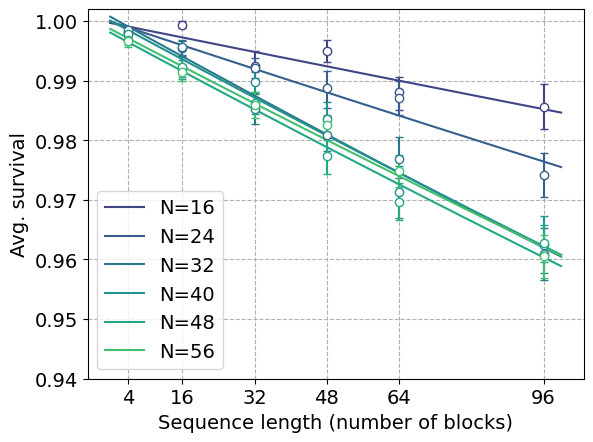

In [7]:
fig, ax = plt.subplots()
fig.set_facecolor('white')
cmap = mpl.colormaps.get_cmap('viridis')
color_list = [cmap(0.2+0.5*(n-16)/(40)) for n in Nrange]

for i, N in enumerate(Nrange):
    ax.errorbar(t1qrb_seq_lengths,[t1qrb_survival[(N,d)] for d in t1qrb_seq_lengths], yerr = np.array(t1qrb_uncertainties[N][3]).transpose(),fmt="o",color=color_list[i], markerfacecolor=[1,1,1],markeredgecolor=color_list[i])
    
for i, N in enumerate(Nrange):
    ax.plot(t1qrb_seq_lengths_interp,exponential_with_asymptote(t1qrb_seq_lengths_interp,t1qrb_uncertainties[N][0][0]-1/2,2*t1qrb_uncertainties[N][1][0]-1,1/2),color=color_list[i], markerfacecolor=[1,1,1],markeredgecolor=color_list[i],label = f'N={N}')

ax.grid(visible=True, axis="both", linestyle="--")
ax.set_xlabel("Sequence length (number of blocks)")
ax.set_ylabel("Avg. survival")
plt.xticks(t1qrb_seq_lengths)
plt.ylim([0.94, 1.002])
plt.legend()
plt.show()

We also plot the average survival for the transport 1Q RB experiment interleaved with the $N=40$ verification circuits.

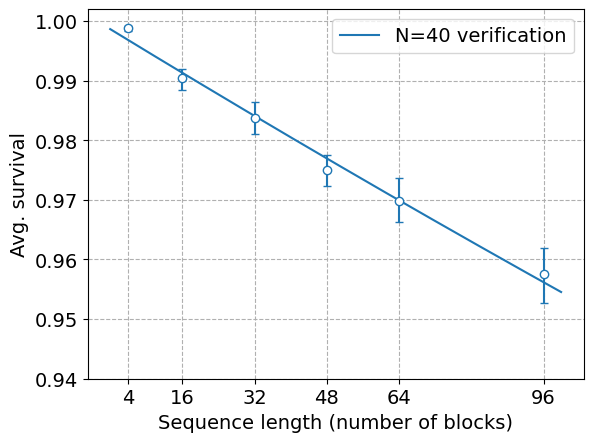

In [8]:
fig, ax = plt.subplots()
fig.set_facecolor('white')
color_list = [plt.get_cmap("tab10").colors[i] for i in range(10)]

ax.errorbar(t1qrb_seq_lengths,[t1qrb_survival_N40_verification[(40,d)] for d in t1qrb_seq_lengths], yerr = np.array(t1qrb_uncertainties_N40_verification[40][3]).transpose(),fmt="o", markerfacecolor=[1,1,1])
ax.plot(t1qrb_seq_lengths_interp,exponential_with_asymptote(t1qrb_seq_lengths_interp,t1qrb_uncertainties_N40_verification[40][0][0]-1/2,2*t1qrb_uncertainties_N40_verification[40][1][0]-1,1/2),color=color_list[0], markerfacecolor=[1,1,1],markeredgecolor=color_list[0],label = "N=40 verification")
ax.grid(visible=True, axis="both", linestyle="--")
ax.set_xlabel("Sequence length (number of blocks)")
ax.set_ylabel("Avg. survival")
plt.xticks(t1qrb_seq_lengths)
plt.ylim([0.94, 1.002])
plt.legend()
plt.show()

Finally, from the various decay curves, we plot $\epsilon_{\rm mem} (N)$ and its empirical logistic function model .

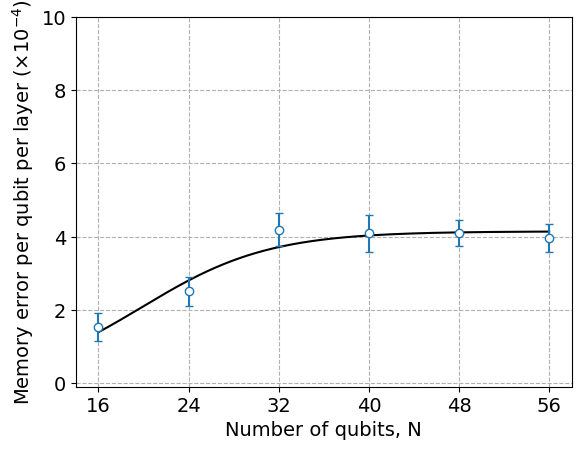

In [9]:
fig, ax = plt.subplots()
fig.set_facecolor('white')

mem_errs = [1-t1qrb_uncertainties[N][1][0] for N in Nrange]
mem_err_uncerts = [t1qrb_uncertainties[N][1][1] for N in Nrange]
popt, perrs = logistic_fit(Nrange, mem_errs, mem_err_uncerts)
ax.plot(Nrange_interp,1e4*logistic(Nrange_interp,popt[0],popt[1],popt[2]),color='black')
ax.errorbar(Nrange,1e4*np.array(mem_errs), yerr = 1e4*np.array(mem_err_uncerts).transpose(),fmt="o", markerfacecolor=[1,1,1],label = "TSQRB survival")
   
ax.grid(visible=True, axis="both", linestyle="--")
ax.set_xlabel("Number of qubits, N")
ax.set_ylabel(r"Memory error per qubit per layer ($\times 10^{-4}$)")
plt.xticks(Nrange)
plt.ylim([-.1,10])
plt.show()

From the logistic function model for $\epsilon_{\rm mem} (N)$ and the measured average 2Q fidelity, we can extract the effective fidelity per 2Q gate.

In [10]:
gc_depth12 = [gate_counting(N,12,effective_2Q(tq_fid, mem_err(N, popt)), spam_fid, eff_tq_depth_shift) for N in Nrange_interp]
gc_depth12_uncerts = [np.sqrt((spam_uncert*N*gc_depth12[i]/spam_fid)**2 + (effective_2Q_uncert(tq_uncert, logistic_err(N,popt[0],popt[1],popt[2],perrs[0],perrs[1],perrs[2]))*(N*(12-eff_tq_depth_shift)/2)*gc_depth12[i]/effective_2Q(tq_fid, mem_err(N,popt)))**2) for i,N in enumerate(Nrange_interp)]
gc_depth12_lower = [gc_depth12[i] - gc_depth12_uncerts[i] for i in range(len(gc_depth12))]
gc_depth12_upper = [gc_depth12[i] + gc_depth12_uncerts[i] for i in range(len(gc_depth12))]

## Plotting fidelity estimates from mirror benchmarking, XEB, and gate counting

With the effective fidelity per 2Q gate at different qubit numbers in hand, we can proceed to compute estimate of fidelity from gate counting. We plot it alongside the estimates of fidelity from XEB and mirror benchmarking computed above.

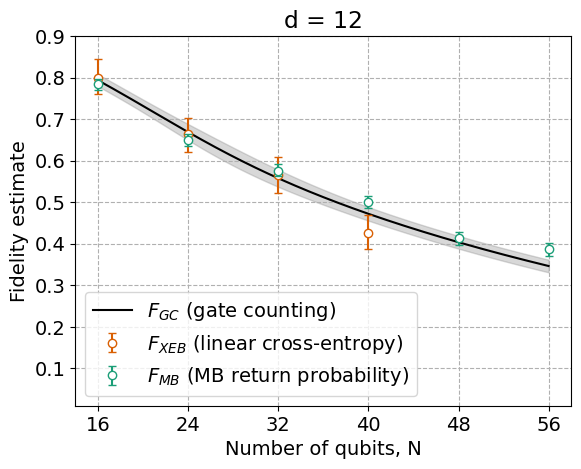

In [11]:
fig, ax = plt.subplots()
fig.set_facecolor('white')
color_list = [plt.get_cmap("Dark2").colors[i] for i in range(7)]

ax.plot(Nrange_interp,gc_depth12, "-", color='black', label = '$F_{GC}$ (gate counting)')
ax.errorbar(Nrange[:4],[xeb[(N,12)] for N in Nrange[:4]], yerr = np.array([xeb_uncertainties[(N,12)] for N in Nrange[:4]]).transpose() ,fmt="o",color=color_list[1], markerfacecolor=[1,1,1],markeredgecolor=color_list[1],label = "$F_{XEB}$ (linear cross-entropy)")
ax.errorbar(Nrange,[mb_fidelity[(N,12)] for N in Nrange], yerr = np.array([mb_uncertainties[(N,12)] for N in Nrange]).transpose(),fmt="o",color=color_list[0], markerfacecolor=[1,1,1],zorder=10,markeredgecolor=color_list[0],label = "$F_{MB}$ (MB return probability)")
ax.fill_between(Nrange_interp, gc_depth12_lower, gc_depth12_upper, alpha = 0.3, color='grey')     
ax.grid(visible=True, axis="both", linestyle="--")
ax.set_xlabel("Number of qubits, N")
ax.set_ylabel("Fidelity estimate")
plt.xticks(Nrange)
plt.legend()
plt.title('d = 12')
plt.ylim([0.01, 0.9])
plt.show()

In [12]:
gc_N56 = [gate_counting(56,d,effective_2Q(tq_fid, mem_errs[-1]), spam_fid, eff_tq_depth_shift) for d in drange_interp]
gc_N56_uncerts = [np.sqrt((spam_uncert*56*gc_N56[i]/spam_fid)**2 + (effective_2Q_uncert(tq_uncert, mem_err_uncerts[-1])*(56*(d-eff_tq_depth_shift)/2)*gc_N56[i]/effective_2Q(tq_fid, mem_errs[-1]))**2) for i,d in enumerate(drange_interp)]
gc_N56_lower = [gc_N56[i] - gc_N56_uncerts[i] for i in range(len(gc_N56))]
gc_N56_upper = [gc_N56[i] + gc_N56_uncerts[i] for i in range(len(gc_N56))]

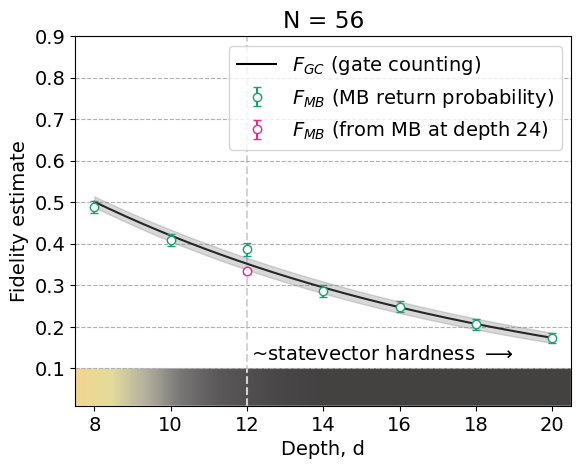

In [13]:
fig, ax = plt.subplots()
fig.set_facecolor('white')
rgb_tuples = [(0.4588973877326169, 0.6791204256957736,0.8886379767392907),(0.6532460537228691, 0.47360381303444854,0.7423175066609748),(0.8002298773104436, 0.43601105321386224, 0.6262037532988443),(0.9108684639751516, 0.6297202346256765, 0.5199328466751674),(0.942417154475004, 0.8094639603666023, 0.48640451246247773),(0.8774495485276863, 0.8377864733546613, 0.5363325097376662),(0.640616457823911, 0.629736334022707, 0.5477426349428957),(0.3632787874974958, 0.3557898867323215, 0.35797929042428006), (0.2412007815655248, 0.23161827390816775, 0.23441958857592546), (0.18688993133389536, 0.176376006346306, 0.17944955191354484),(0.14939975360681784, 0.1382428815635377, 0.14150434510224663), (0.133532, 0.122103, 0.125444),(0.133532, 0.122103, 0.125444),(0.133532, 0.122103, 0.125444),(0.133532, 0.122103, 0.125444),(0.133532, 0.122103, 0.125444),(0.133532, 0.122103, 0.125444),(0.133532, 0.122103, 0.125444),(0.133532, 0.122103, 0.125444)]
cm1 = LinearSegmentedColormap.from_list('',rgb_tuples[4:])
cm1.set_bad('#FFFFFF')
color_list = [plt.get_cmap("Dark2").colors[i] for i in range(7)]
alpha = 0.85

mb24_d12_estimate = np.sqrt(mb_fidelity[(56,24)]/(spam_fid)**56)*(spam_fid)**56 
mb24_d12_lower_unc = np.sqrt((mb_uncertainties[(56,24)][0]*mb24_d12_estimate/(2*mb_fidelity[(56,24)]))**2+(spam_uncert*28*mb24_d12_estimate / spam_fid)**2)
mb24_d12_upper_unc = np.sqrt((mb_uncertainties[(56,24)][1]*mb24_d12_estimate/(2*mb_fidelity[(56,24)]))**2+(spam_uncert*28*mb24_d12_estimate / spam_fid)**2)
ax.plot(drange_interp,gc_N56, "-", color='black', label = '$F_{GC}$ (gate counting)',zorder=2)
ax.errorbar(drange,[mb_fidelity[(56,d)] for d in drange], yerr = np.array([mb_uncertainties[(56,d)] for d in drange]).transpose(),fmt="o",color=color_list[0], markerfacecolor=[1,1,1],markeredgecolor=color_list[0],label = "$F_{MB}$ (MB return probability)")
ax.errorbar([12],[mb24_d12_estimate], yerr = np.array([(mb24_d12_lower_unc,mb24_d12_upper_unc)]).transpose(),fmt="o",color=color_list[3], markerfacecolor=[1,1,1],markeredgecolor=color_list[3],label = "$F_{MB}$ (from MB at depth 24)")
ax.fill_between(drange_interp, gc_N56_lower, gc_N56_upper, alpha = 0.3, color='grey',zorder=2)

x, y = np.meshgrid(np.linspace(7.5, 20.5, 1000), np.linspace(.01, 0.1, 1000))
p=ax.fill_between(np.arange(7.5,20.5,0.01),[0.01 for _ in np.arange(7.5,20.5,0.01)],[0.1 for _ in np.arange(7.5,20.5,0.01)],alpha=alpha,color='none')
gradient = plt.imshow(x,cmap=cm1, aspect='auto', origin='lower',extent = [7.5,20.5,.01,0.1],alpha=alpha)
gradient.set_clip_path(p.get_paths()[0], transform=plt.gca().transData)

ax.grid(visible=True, axis="y", linestyle="--")
ax.set_xlabel("Depth, d", fontsize=14)
ax.annotate(r'~statevector hardness $\longrightarrow$',(12.1,0.02),xytext=(12.1,0.12), color='black',alpha=1)
ax.set_ylabel("Fidelity estimate",  fontsize=14)
ax.axvline(x=12, color='#d3d3d3', ls='--',zorder=1)
plt.xticks(drange)
plt.legend()
plt.title('N = 56')
plt.ylim([0.01, 0.9])
ax.set_xlim([7.5,20.5])
plt.show()

In [14]:
mem_err_N40 = 1-t1qrb_uncertainties_N40_verification[40][1][0]
mem_uncert_N40 = t1qrb_uncertainties[40][1][1]
gc_N40 = [gate_counting(40,d,effective_2Q(tq_fid, mem_err_N40), spam_fid, eff_tq_depth_shift) for d in drange_interp]
gc_N40_uncerts = [np.sqrt((spam_uncert*40*gc_N40[i]/spam_fid)**2 + (effective_2Q_uncert(tq_uncert, mem_uncert_N40)*(40*(d-eff_tq_depth_shift)/2)*gc_N40[i]/effective_2Q(tq_fid, mem_err_N40))**2) for i,d in enumerate(drange_interp)]
gc_N40_lower = [gc_N40[i] - gc_N40_uncerts[i] for i in range(len(gc_N40))]
gc_N40_upper = [gc_N40[i] + gc_N40_uncerts[i] for i in range(len(gc_N40))]

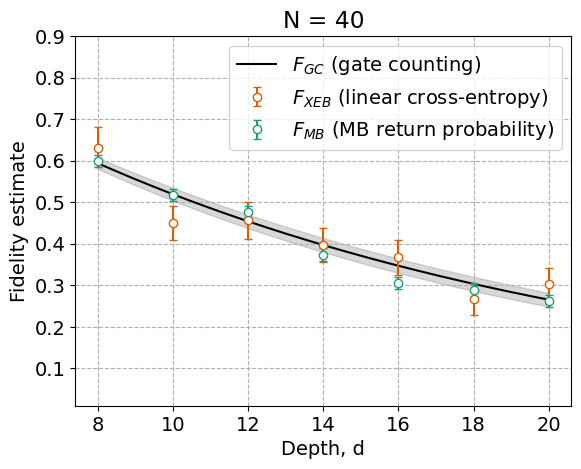

In [15]:
fig, ax = plt.subplots()
fig.set_facecolor('white')
color_list = [plt.get_cmap("Dark2").colors[i] for i in range(7)]

ax.plot(drange_interp,gc_N40, "-", color='black', label = '$F_{GC}$ (gate counting)')
ax.errorbar(drange,[xeb_N40_verification[(40,d)] for d in drange], yerr = np.array([xeb_uncertainties_N40_verification[(40,d)] for d in drange]).transpose(),fmt="o",color=color_list[1], markerfacecolor=[1,1,1],markeredgecolor=color_list[1],label = "$F_{XEB}$ (linear cross-entropy)")
ax.errorbar(drange,[mb_fidelity_N40_verification[(40,d)] for d in drange], yerr = np.array([mb_uncertainties_N40_verification[(40,d)] for d in drange]).transpose(),fmt="o",color=color_list[0], markerfacecolor=[1,1,1],markeredgecolor=color_list[0],label = "$F_{MB}$ (MB return probability)")
ax.fill_between(drange_interp, gc_N40_lower, gc_N40_upper, alpha = 0.3, color='grey')     
ax.grid(visible=True, axis="both", linestyle="--")
ax.set_xlabel("Depth, d", fontsize=14)
ax.set_ylabel("Fidelity estimate")
plt.xticks(drange)
plt.legend()
plt.title('N = 40')
plt.ylim([0.01, 0.9])
plt.show()

<div align="center"> &copy; 2024 by Quantinuum. All Rights Reserved. </div>